In [0]:
import os
from scipy.io import wavfile
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from keras.layers import Conv2D, MaxPool2D, Flatten, LSTM , BatchNormalization
from keras.layers import Dropout, Dense, TimeDistributed
from keras.models import Sequential
from keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm
from python_speech_features import mfcc

In [0]:
class Config :
    def __init__(self , mode = 'conv' , nfilt = 26 , n_feat = 13 , nfft = 512 , rate = 16000):
        self.mode = mode
        self.nfilt = nfilt
        self.n_feat = n_feat
        self.nfft = nfft
        self.rate = rate
        self.step = int(rate/10)

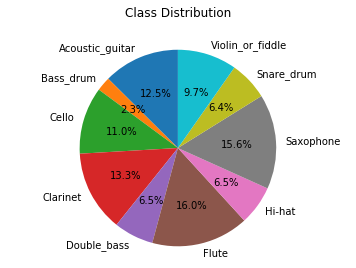

In [0]:
df = pd.read_csv('instruments.csv')
df.set_index('fname', inplace=True)

for f in df.index:
    rate, signal = wavfile.read('clean/'+f)
    df.at[f, 'length'] = signal.shape[0]/rate

classes = list(np.unique(df.label))
class_dist = df.groupby(['label'])['length'].mean()

fig, ax = plt.subplots()
ax.set_title('Class Distribution', y=1.08)
ax.pie(class_dist, labels=class_dist.index, autopct='%1.1f%%',
       shadow=False, startangle=90)
ax.axis('equal')
plt.show()

####Reading from clean dir , after preprocessing the audio#####

In [0]:
n_samples = 2*int(df['length'].sum()/0.1)

In [0]:
prob_dist = class_dist/class_dist.sum()  ##Everything between 0-1
prob_dist

label
Acoustic_guitar     0.125490
Bass_drum           0.023364
Cello               0.110363
Clarinet            0.133404
Double_bass         0.065382
Flute               0.159950
Hi-hat              0.064699
Saxophone           0.155962
Snare_drum          0.064010
Violin_or_fiddle    0.097375
Name: length, dtype: float64

In [0]:
choices = np.random.choice(class_dist.index , p = prob_dist) 
print(choices)  ##selects a random choice based on probability distribution of class_dist 

Flute


In [0]:
config = Config(mode = 'conv')


In [0]:
def build_random_feat():
    X=[]
    y=[]
    _min , _max = float('inf') , -float('inf')
    
    for _ in (range(n_samples)):
        random_class = np.random.choice(class_dist.index , p = prob_dist) ##randomly select a class
        file = np.random.choice(df[df.label == random_class].index) ##select a random file for the slected class
        rate , wav = wavfile.read(filename = 'clean/'+file)
        label = df.at[file , 'label']
        rand_index = np.random.randint(0,wav.shape[0]- config.step)

        sample = wav[rand_index : rand_index + config.step]

        X_sample = mfcc(sample , numcep=config.n_feat,nfilt=config.nfilt,nfft = config.nfft ).T
        
        
        _min = min(np.amin(X_sample) , _min)
        _max = max(np.amax(X_sample) , _max)
        
        X.append(X_sample if config.mode =='conv' else X_sample.T)
        y.append(classes.index(label))
        
       
    X , y = np.array(X) , np.array(y)
    X = (X - _min)/(_max - _min )

       

    if config.mode == 'conv' :
            X = X.reshape(X.shape[0] , X.shape[1] , X.shape[2] , 1)
    elif config.mode == 'rnn' :
            X = X.reshape(X.shape[0] , X.shape[1] , X.shape[2])
    y = to_categorical(y , num_classes=10)

    return X , y




In [0]:
##set config mode
config.mode = 'rnn'

In [0]:
if config.mode == 'conv':
    X , y = build_random_feat()
elif config.mode == 'rnn':
    X , y = build_random_feat()

In [0]:
import pickle

pickle_out = open("X_{0}.pickle".format(config.mode),"wb")
pickle.dump(X, pickle_out)
pickle_out.close()

pickle_out = open("y_{0}.pickle".format(config.mode),"wb")
pickle.dump(y, pickle_out)
pickle_out.close()



In [0]:
########################Training###################

In [0]:
def get_conv_model() :
    model = Sequential()
    model.add(Conv2D(16 , (3,3), strides=(1,1), padding = 'same' , activation = 'relu' , input_shape = input_shape))
    model.add(BatchNormalization())
    model.add(Conv2D(32 , (3,3), strides=(1,1), padding = 'same' , activation = 'relu' ))
    model.add(BatchNormalization())
    model.add(Conv2D(64 , (3,3), strides=(1,1), padding = 'same' , activation = 'relu' ))
    model.add(BatchNormalization())
    model.add(Conv2D(128 , (3,3), strides=(1,1), padding = 'same' , activation = 'relu' ))
    model.add(MaxPool2D((2,2)))
    model.add(Dropout(0.35))
    model.add(Flatten())
    model.add(Dense(128 , activation = 'relu'))
    model.add(Dense(64 , activation = 'relu'))
    model.add(Dense(32 , activation = 'relu'))
    model.add(Dense(10 , activation = 'softmax'))

    model.summary()
    model.compile(loss = 'categorical_crossentropy' , optimizer = 'adam' , metrics = ['acc'])

    return model


In [0]:
def get_rnn_model() :
    model = Sequential()
    model.add(LSTM(128 , return_sequences=True , input_shape = input_shape))
    model.add(LSTM(128 ,return_sequences=True ))
    model.add(Dropout(0.5))
    model.add(TimeDistributed(Dense(64 , activation='relu')))
    model.add(TimeDistributed(Dense(32 , activation='relu')))
    model.add(TimeDistributed(Dense(16 , activation='relu')))
    model.add(TimeDistributed(Dense(8 , activation='relu')))
    model.add(Flatten())
    model.add(Dense(10 , activation ='softmax'))
    model.compile(loss = 'categorical_crossentropy' , optimizer = 'adam' , metrics = ['acc'])
    #model.summary()

    return model

In [0]:
if config.mode == 'conv' :
    pickle_in = open("X_conv.pickle","rb")
    X_conv = pickle.load(pickle_in)
    pickle_in.close()

    pickle_in = open("y_conv.pickle","rb")
    y_conv = pickle.load(pickle_in)
    pickle_in.close()

    y_flat = np.argmax(y_conv,axis = 1)

    input_shape = (X_conv.shape[1] , X_conv.shape[2], 1)

    model = get_conv_model()
elif config.mode == 'rnn' :
    pickle_in = open("X_rnn.pickle","rb")
    X_rnn = pickle.load(pickle_in)
    pickle_in.close()

    pickle_in = open("y_rnn.pickle","rb")
    y_rnn = pickle.load(pickle_in)
    pickle_in.close()

    y_flat = np.argmax(y_rnn,axis = 1)

    input_shape = (X_rnn.shape[1] , X_rnn.shape[2])

    rnn_model = get_rnn_model()




In [0]:
rnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 9, 128)            72704     
_________________________________________________________________
lstm_4 (LSTM)                (None, 9, 128)            131584    
_________________________________________________________________
dropout_5 (Dropout)          (None, 9, 128)            0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, 9, 64)             8256      
_________________________________________________________________
time_distributed_6 (TimeDist (None, 9, 32)             2080      
_________________________________________________________________
time_distributed_7 (TimeDist (None, 9, 16)             528       
_________________________________________________________________
time_distributed_8 (TimeDist (None, 9, 8)              136       
__________

In [0]:
class_weight = compute_class_weight('balanced' , np.unique(y_flat) , y_flat)



In [0]:
model.fit(X , y , epochs = 20 , batch_size = 2048 , shuffle = True , class_weight =  class_weight)

Epoch 1/10
26410/26410 [==============================] - 2s 78us/step - loss: 0.2565 - acc: 0.9146
Epoch 2/10
26410/26410 [==============================] - 2s 76us/step - loss: 0.2317 - acc: 0.9220
Epoch 3/10
26410/26410 [==============================] - 2s 76us/step - loss: 0.2143 - acc: 0.9276
Epoch 4/10
26410/26410 [==============================] - 2s 76us/step - loss: 0.2047 - acc: 0.9307
Epoch 5/10
26410/26410 [==============================] - 2s 76us/step - loss: 0.1852 - acc: 0.9383
Epoch 6/10
26410/26410 [==============================] - 2s 76us/step - loss: 0.1647 - acc: 0.9453
Epoch 7/10
26410/26410 [==============================] - 2s 76us/step - loss: 0.1495 - acc: 0.9507
Epoch 8/10
26410/26410 [==============================] - 2s 76us/step - loss: 0.1431 - acc: 0.9527
Epoch 9/10
26410/26410 [==============================] - 2s 76us/step - loss: 0.1266 - acc: 0.9579
Epoch 10/10
26410/26410 [==============================] - 2s 76us/step - loss: 0.1208 - acc: 0.9607

In [0]:
model.save("speech_conv.h5")

In [0]:
rnn_model.fit(X , y , epochs = 50 , batch_size = 4096 , shuffle = True , class_weight =  class_weight)

Epoch 1/10
26410/26410 [==============================] - 1s 32us/step - loss: 0.7125 - acc: 0.7604
Epoch 2/10
26410/26410 [==============================] - 1s 31us/step - loss: 0.6987 - acc: 0.7666
Epoch 3/10
26410/26410 [==============================] - 1s 31us/step - loss: 0.6871 - acc: 0.7679
Epoch 4/10
26410/26410 [==============================] - 1s 31us/step - loss: 0.6773 - acc: 0.7731
Epoch 5/10
26410/26410 [==============================] - 1s 31us/step - loss: 0.6654 - acc: 0.7772
Epoch 6/10
26410/26410 [==============================] - 1s 31us/step - loss: 0.6511 - acc: 0.7817
Epoch 7/10
26410/26410 [==============================] - 1s 31us/step - loss: 0.6667 - acc: 0.7764
Epoch 8/10
26410/26410 [==============================] - 1s 31us/step - loss: 0.6473 - acc: 0.7820
Epoch 9/10
26410/26410 [==============================] - 1s 31us/step - loss: 0.6461 - acc: 0.7798
Epoch 10/10
26410/26410 [==============================] - 1s 31us/step - loss: 0.6119 - acc: 0.7952

In [0]:
rnn_model.save("speech_rnn.h5")